<a href="https://colab.research.google.com/github/olorunfemibabalola/Depression-Tweet-Classifier/blob/main/Code_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROJECT:** Depression Risk and Intent Classifier for Tweets

**UNIT:** Machine Learning and Applications

**AUTHOR:** Babalola Praise Olorunfemi

**STUDENT ID:** s5819556

LIBRARY SETUP

In [39]:
# This cell installs all the Python libraries we need for our project.
print("\n🔄 EXECUTING -> Setting up libraries...\n\n")
!pip install shap nltk pandas numpy scikit-learn matplotlib seaborn requests beautifulsoup4 imbalanced-learn
print("\n✅ Libraries succesfully installed!!")


🔄 EXECUTING -> Setting up libraries...



✅ Libraries succesfully installed!!


In [40]:
# This cell imports specific tools (modules/classes) from the installed libraries we need for this project.
print("\n🔄 EXECUTING -> Importing libraries...\n")
import pandas as pd
import numpy as np
import re
import nltk
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, recall_score, f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler

print("\n✅ Libraries imported successfully!")


🔄 EXECUTING -> Importing libraries...


✅ Libraries imported successfully!


In [41]:
# `vader_lexicon` is for sentiment analysis, and `stopwords` is for removing common words like 'the', 'a', 'is'.
nltk.download('vader_lexicon', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [42]:
# `RANDOM_STATE = 42` ensures that random operations are reproducible.
# `MAX_FEATURES = 1000` limits the number of features created by TF-IDF (Term Frequency-Inverse Document Frequency).
RANDOM_STATE = 42
MAX_FEATURES = 1000  # For TF-IDF to keep training fast

**DATA ACQUISITION / SYNTHESIS**

**DATA SYNTHESIS:**
This function generates synthetic data if real data is missing. It's like a backup dataset!
Ensures the pipeline runs immediately without crashing.
    

In [43]:
def generate_synthetic_data(n_samples=3000):

    print("\n⚠️  DATA STATUS: Real CSV not found. Generating SYNTHETIC DATA...")

    data = {'text': [], 'risk_label': [], 'intent': []}

    # Intent: Cry for Help (High Risk)
    helps = [
        "I can't do this anymore, please someone help.", "Planning to end it tonight.",
        "There is no hope left, I want the pain to stop.", "I feel like I'm drowning.",
        "Goodbye everyone, I can't take this life anymore."
    ]
    # Intent: Venting (Medium/High Risk)
    vents = [
        "So frustrated with everything right now.", "Why is life so exhausting?",
        "Crying in my room again, standard Tuesday.", "My anxiety is through the roof.",
        "I hate how I feel, just needed to say it."
    ]
    # Intent: Loneliness (Medium Risk)
    lonely = [
        "I haven't spoken to a human in days.", "Does anyone else feel invisible?",
        "I miss having friends who care.", "The silence is too loud.",
        "Just sitting here alone again."
    ]
    # Intent: Neutral (Low Risk)
    neutral = [
        "Watching Netflix and chilling.", "Great workout today!",
        "Anyone see the game last night?", "Coffee is life.",
        "Just finished my homework."
    ]

    for _ in range(n_samples // 4):
        data['text'].append(np.random.choice(helps))
        data['risk_label'].append(1)
        data['intent'].append("Cry for Help")

        data['text'].append(np.random.choice(vents))
        data['risk_label'].append(1)
        data['intent'].append("Venting")

        data['text'].append(np.random.choice(lonely))
        data['risk_label'].append(1)
        data['intent'].append("Loneliness")

        data['text'].append(np.random.choice(neutral))
        data['risk_label'].append(0)
        data['intent'].append("Neutral")

    return pd.DataFrame(data)

**DATA ACQUISITION:**
Tries to load our main dataset ('Suicide_Detection.csv').
If it can't find it, it falls back to making fake data using the function`generate_synthetic_data`.
    

In [44]:
def load_and_prep_data():

    # Check for Raw Kaggle file
    try:
        df_raw = pd.read_csv('Suicide_Detection.csv', on_bad_lines='skip', engine='python') # Attempt to read the CSV file
        print("✅ DATA STATUS: Loaded raw 'Suicide_Detection.csv'. processing sample...") # Confirm successful loading

        df_high = df_raw[df_raw['class'] == 'suicide'].sample(5000, random_state=RANDOM_STATE) # Sample 5000 'suicide' tweets
        df_low = df_raw[df_raw['class'] == 'non-suicide'].sample(4500, random_state=RANDOM_STATE) # Sample 4500 'non-suicide' tweets
        df = pd.concat([df_high, df_low]).sample(frac=1).reset_index(drop=True) # Combine samples, shuffle, and reset index

        # Map Risk
        df['risk_label'] = df['class'].map({'suicide': 1, 'non-suicide': 0}) # Create a numerical risk label (1 for suicide, 0 for non-suicide)

        # Labels Intent
        def get_intent(text):
            t = str(text).lower() # Convert text to lowercase
            if any(x in t for x in ['help', 'end', 'die', 'suicide', 'goodbye', 'kill', 'death', 'can\'t go on with life', 'over it', 'wish i wasn\'t here', 'i give up', 'no more', 'escape', 'fade away', 'take me away', 'done with life']): return "Cry for Help" # Check for 'Cry for Help' keywords
            if any(x in t for x in ['alone', 'lonely', 'nobody', 'friend', 'no one', 'no friend', 'isolated', 'by myself', 'solitude', 'deserted', 'forgotten', 'empty house', 'on my own', 'single', 'unaccompanied']): return "Loneliness" # Check for 'Loneliness' keywords
            if any(x in t for x in ['tired', 'sad', 'cry', 'pain', 'hate', 'not good enough', 'it sucks', 'losing myself', 'losing', 'frustrated', 'stressed', 'annoyed', 'upset', 'angry', 'suffering', 'miserable', 'depressed', 'unhappy', 'agony']): return "Venting" # Check for 'Venting' keywords
            if any(x in t for x in ['good', 'happy', 'great', 'fun', 'enjoy', 'positive', 'chill', 'relax', 'weekend', 'food', 'movie', 'book', 'game', 'learn', 'work', 'study', 'exercise', 'music', 'art', 'news', 'weather', 'sleep', 'rest']): return "Neutral" # Check for 'Neutral' keywords
            return "Neutral" # Default to 'Neutral' if no specific intent is found

        df['intent'] = df.apply(lambda x: get_intent(x['text']) if x['risk_label'] == 1 else "Neutral", axis=1) # This intent labeling: only classify intent for high-risk tweets, otherwise 'Neutral'

        return df[['text', 'risk_label', 'intent']] # Return the DataFrame with relevant columns

    except FileNotFoundError: # Catch the error if the CSV file is not found
        pass # Do nothing, allowing the code to proceed to the generate synthetic data

    # 3. Fallback
    return generate_synthetic_data() # If the file is not found, generate and return synthetic data

In [45]:
# This helps us see how balanced our dataset is for different types of tweet intents.
df = load_and_prep_data() # Load the data and assign it to df
print("\n📊 Intent Label Distribution (after data prep):")
print(df['intent'].value_counts())

✅ DATA STATUS: Loaded raw 'Suicide_Detection.csv'. processing sample...

📊 Intent Label Distribution (after data prep):
intent
Neutral         4998
Cry for Help    4154
Venting          197
Loneliness       151
Name: count, dtype: int64


**PREPROCESSING & FEATURE ENGINEERING**


**PREPROCESSING:**
This function cleans up the tweet text by removing what we don't need, like links, mentions, hashtags, and punctuation.

In [46]:
def clean_tweet(text):
    text = str(text).lower()               # Convert all text to lowercase
    text = re.sub(r'http\S+', '', text)    # Remove URLs that start with http or https
    text = re.sub(r'@\w+', '', text)       # Remove mentions (e.g., @username)
    text = re.sub(r'#', '', text)          # Remove hashtag symbols (e.g., #topic becomes topic)
    text = re.sub(r'[^\w\s]', '', text)    # Remove punctuation and special characters, keep words and spaces
    return text.strip()                    # Remove leading/trailing whitespace

MULTIMODAL FUSION:
We turn the text into numbers by combining different types of features
*   The length of the tweet.
*   How positive or negative the tweet sounds (sentiment).
*   Important keywords using TF-IDF (Term Frequency-Inverse Document Frequency).





In [47]:
def multimodal_fusion(df):

    print("\n🔄 EXECUTION: Running Multimodal Feature Fusion...")

    # 1. Tweet Length
    # We add the length of the cleaned tweet as a feature. Longer tweets might mean more info!
    df['text_len'] = df['text'].apply(len) # Calculate the length of each tweet text

    # 2. VADER Sentiment
    # We use VADER (Valence Aware Dictionary and sEntiment Reasoner) to get a sentiment score for each tweet.
    # 'compound_sent' ranges from -1 (most negative) to +1 (most positive).
    sid = SentimentIntensityAnalyzer() # Initialize VADER sentiment analyzer
    df['compound_sent'] = df['text'].apply(lambda x: sid.polarity_scores(str(x))['compound']) # Get compound sentiment score for each tweet

    # 3. TF-IDF
    # TF-IDF (Term Frequency-Inverse Document Frequency) converts text into numerical vectors.
    # MAX_FEATURES limits it to the most important 1000 words to keep it fast.
    tfidf = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english') # Initialize TF-IDF vectorizer, limit features and remove common English words
    tfidf_matrix = tfidf.fit_transform(df['cleaned_text']) # Learn vocabulary and transform cleaned text into TF-IDF matrix
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out()) # Convert TF-IDF matrix to DataFrame with feature names

    # FUSION STEP: Concatenate all features
    # We combine the TF-IDF features, sentiment score, and tweet length into one big feature matrix (X).
    # This 'fused' matrix is what our machine learning model will train on.
    X = pd.concat([ # Combine all feature DataFrames horizontally
        tfidf_df.reset_index(drop=True),
        df[['compound_sent', 'text_len']].reset_index(drop=True) # Add sentiment and length features
    ], axis=1)

    print(f"   Shape of Fused Feature Matrix: {X.shape}") # Print the shape of the combined feature matrix
    return X, tfidf, sid # Return the fused features, TF-IDF vectorizer, and sentiment analyzer

OVERSAMPLING DATASET

Applies **RandomOverSampler** to balance 'intent' labels, specifically for 'Venting' and 'Loneliness' that have lower counts in the dataset, it reconstructs the target DataFrame with risk labels.

In [48]:
def apply_oversampling(X, Y, le):

    print("\n🔄 EXECUTING -> Applying RandomOverSampler to balance intent classes...")

    # Instantiate RandomOverSampler
    # RandomOverSampler helps balance classes by randomly duplicating samples from minority classes.
    # This prevents the model from being biased towards majority classes (like 'Neutral').
    ros = RandomOverSampler(random_state=RANDOM_STATE) # Initialize the RandomOverSampler

    # Apply oversampling to X (features) and the 'intent_enc' column of Y (target intent).
    # This increases the number of samples for underrepresented 'intent' categories.
    X_resampled, y_intent_resampled = ros.fit_resample(X, Y['intent_enc']) # Resample features and encoded intent

    # Create a new DataFrame for Y_resampled from y_intent_resampled.
    # We need to reconstruct the target DataFrame with both risk and intent.
    Y_resampled = pd.DataFrame(y_intent_resampled, columns=['intent_enc']) # Create DataFrame for resampled intent

    # Add 'risk_label' column to Y_resampled
    # We determine the risk label based on the encoded intent. 'Neutral' intent means 'No Risk' (0).
    try:
        neutral_encoded = le.transform(['Neutral'])[0] # Get the encoded value for 'Neutral'
    except ValueError:
        print("Warning: 'Neutral' not found in label encoder classes. Assuming 0 for 'Neutral'.")
        neutral_encoded = 0 # Fallback if 'Neutral' is not in the original labels

    Y_resampled['risk_label'] = Y_resampled['intent_enc'].apply(lambda x: 0 if x == neutral_encoded else 1) # Assign risk based on intent

    '''
    print(f"   Original dataset size: {len(X)}")
    print(f"   Resampled dataset size: {len(X_resampled)}")
    print("   Intent distribution after oversampling:")
    print(le.inverse_transform(Y_resampled['intent_enc'].value_counts().index.tolist()))
    print(Y_resampled['intent_enc'].value_counts())
    '''

    # Reorder columns to match original Y structure [risk_label, intent_enc]
    # Ensure the output format is consistent.
    Y_resampled = Y_resampled[['risk_label', 'intent_enc']] # Reorder columns to expected format

    return X_resampled, Y_resampled # Return the resampled features and targets

**PRESCRIPTIVE ENGINE:**

This function gives a helpful suggestion based on the predicted intent of the users text or tweet.
    

In [49]:
def get_wellness_suggestion(intent_label):
  # We define a dictionary mapping intent labels to prescribed wellness suggestions
    strategies = {
        "Cry for Help": "🔴 URGENT: High distress detected. Please contact a helpline immediately. Grounding: Name 5 things you can see.",
        "Venting": "🔵 Insight: Emotional release is healthy. Suggestion: Take time off or try expressive journaling to process these feelings.",
        "Loneliness": "🟡 Insight: Isolation detected. Suggestion: Reach out to a trusted friend or join an online community.",
        "Neutral": "🟢 Status: No risk detected. Suggestion: Maintain current self-care routine.",
        "Unknown": "⚪ Suggestion: Monitor mood."
    }
    # If the intent is found, it returns the specific strategy; otherwise, a general 'Unknown' suggestion.
    return strategies.get(intent_label, strategies['Unknown']) # Get the suggestion for the given intent, default to 'Unknown'

**URL HANDLING:**

This function allows for the user to input or share the link to a tweet and gets the actual tweet or text from the link!


In [50]:
# This function tries to extract the text content from a given Twitter URL.
# It uses 'requests' to fetch the webpage and 'BeautifulSoup' to parse its HTML.
# The 'User-Agent' header is set to mimic a Discord bot, which sometimes helps bypass site restrictions.
def get_tweet_from_url(url):
    print(f"\n🔗 URL Detected: {url}")
    headers = {'User-Agent': 'Mozilla/5.0 (compatible; Discordbot/2.0; +https://discordapp.com)'} # Set a User-Agent header
    try:
        response = requests.get(url, headers=headers, timeout=5) # Send HTTP GET request to the URL with a timeout
        if response.status_code == 200: # Check if the request was successful (HTTP status 200)
            soup = BeautifulSoup(response.text, 'html.parser') # Parse the HTML content of the page
            # It looks for the 'og:description' meta tag, which usually contains the tweet's text.
            meta = soup.find('meta', property='og:description') # Find the meta tag with property 'og:description'
            if meta: return meta['content'].strip('“').strip('”') # If found, extract and clean the content
        # If no meta description is found or the request fails, it returns an error message.
        return f"ERROR: Could not find tweet content from URL. Status code: {response.status_code}. Please ensure the URL is correct and the tweet is public." # Return an error message
    except requests.exceptions.RequestException as e:
        # Catches network-related errors.
        return f"ERROR: Failed to retrieve URL content. Please ensure it's a valid public Twitter URL. Error: {e}" # Handle network request errors
    except Exception as e:
        # Catches any other unexpected errors.
        return f"ERROR: An unexpected error occurred while processing the URL. Error: {e}" # Handle other unexpected errors

**MODEL EVALUATION:**

They function evaluates the model's performance, generates plots, performs SHAP explainability, and conducts an ethical fairness check.
    

In [51]:
def evaluate_model(Y_test, lr_pred, rf_pred, rf, X_test, tfidf_vectorizer, sid, le, run_shap=True):
    print("\n🔄 EXECUTING -> Evaluating Model...")
    # Metrics Calculation & Plotting: How well did the models do?
    # Helper function to get recall, precision, and F1 for the risk prediction.
    def get_metrics(y_true, y_pred):
        risk_true = y_true.iloc[:,0] # Extract actual risk labels from the first column of Y_test
        risk_pred = y_pred[:,0] # Extract predicted risk labels from the first column of predictions
        recall = recall_score(risk_true, risk_pred) # Calculate recall score
        precision = precision_score(risk_true, risk_pred, zero_division=0) # Calculate precision score, handling zero division
        f1 = f1_score(risk_true, risk_pred, average='weighted') # Calculate weighted F1-score for overall performance
        return recall, precision, f1 # Return the calculated metrics

    # Calculate metrics for both Logistic Regression and Random Forest models.
    lr_recall, lr_precision, lr_f1 = get_metrics(Y_test, lr_pred) # Get metrics for Logistic Regression
    rf_recall, rf_precision, rf_f1 = get_metrics(Y_test, rf_pred) # Get metrics for Random Forest

    # Print out a neat table of results for easy comparison.
    print(f"\n📊 RESULTS TABLE :") # Header for results table
    print(f"   Model                |    Risk Recall  |   Risk Precision   | F1-Score (Weighted)") # Column headers
    print(f"   ---------------------|-----------------|--------------------|--------------------") # Separator
    print(f"   Logistic Regression  |     {lr_recall:.2%}      |       {lr_precision:.2%}       |      {lr_f1:.2%}   ") # LR results
    print(f"   Random Forest        |     {rf_recall:.2%}      |       {rf_precision:.2%}       |      {rf_f1:.2%}   ") # RF results

    # Plot a comparison of the metrics (Recall, Precision, F1-Score) for both models.
    plt.figure(figsize=(10,6)) # Create a new figure for the plot
    bar_width = 0.2 # Width of each bar in the bar chart
    index = np.arange(2) # X-axis locations for the bars (0 and 1 for two models)

    plt.bar(index, [lr_recall, rf_recall], bar_width, label='Recall', color='teal') # Plot recall bars
    plt.bar(index + bar_width, [lr_precision, rf_precision], bar_width, label='Precision', color='orange') # Plot precision bars
    plt.bar(index + 2*bar_width, [lr_f1, rf_f1], bar_width, label='F1-Score', color='purple') # Plot F1-score bars

    plt.xlabel('Model') # X-axis label
    plt.ylabel('Score') # Y-axis label
    plt.title('Model Performance Comparison (Risk Label)') # Plot title
    plt.xticks(index + bar_width, ['Logistic Regression', 'Random Forest']) # Set x-axis labels for models
    plt.legend() # Display legend for metrics
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.savefig("comparison_metrics_plot.png") # Save the plot as an image file.
    print("   -> Saved 'comparison_metrics_plot.png'") # Confirm plot saved

    # Confusion Matrix for Random Forest (Risk Label): Visualizing correct/incorrect predictions.
    # This helps see where the model gets confused (e.g., misclassifying high risk as low risk).
    print("\n📉 CONFUSION MATRIX: Generating for Random Forest (Risk Label)...")
    cm = confusion_matrix(Y_test.iloc[:,0], rf_pred[:,0]) # Calculate confusion matrix for Random Forest risk predictions
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Risk', 'High Risk']) # Prepare confusion matrix for display with custom labels
    plt.figure(figsize=(6,6)) # Create a new figure for the confusion matrix
    disp.plot(cmap=plt.cm.Blues, values_format='d') # Plot the confusion matrix with a blue colormap and integer format
    plt.title('Confusion Matrix: Random Forest (Risk Label)') # Set title for the plot
    plt.savefig("confusion_matrix_rf.png") # Save the confusion matrix plot.
    print("   -> Saved 'confusion_matrix_rf.png'") # Confirm plot saved

    # Confusion Matrix for Logistic Regression (Risk Label).
    print("\n📉 CONFUSION MATRIX: Generating for Logistic Regression (Risk Label)...")
    cm = confusion_matrix(Y_test.iloc[:,0], lr_pred[:,0]) # Calculate confusion matrix for Logistic Regression risk predictions
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Risk', 'High Risk']) # Prepare confusion matrix for display
    plt.figure(figsize=(6,6)) # Create a new figure
    disp.plot(cmap=plt.cm.Blues, values_format='d') # Plot the confusion matrix
    plt.title('Confusion Matrix: Logistic Regression (Risk Label)') # Set title
    plt.savefig("confusion_matrix_lr.png") # Save the confusion matrix plot.
    print("   -> Saved 'confusion_matrix_lr.png'") # Confirm plot saved

    # 6. SHAP Explainability: Why did the model make that decision?
    # SHAP (SHapley Additive exPlanations) helps understand which features contributed most to a prediction.
    # This is often computationally intensive, so it's made optional with `run_shap`.
    if run_shap: # Check if SHAP explainability is enabled
        print("\n🔍 EXPLAINABILITY: Generating SHAP Summary Plot...") # Indicate SHAP plot generation
        explainer = shap.TreeExplainer(rf.estimators_[0]) # Initialize SHAP explainer for the first random forest estimator

        # Sample a small part of the test set for faster SHAP calculation
        shap_sample = X_test.sample(n=100, random_state=RANDOM_STATE) # Take a random sample of 100 instances from X_test
        # Get SHAP values, focusing on the positive class (risk_label=1) to see what drives 'high risk' predictions.
        shap_values = explainer.shap_values(shap_sample, check_additivity=False) # Compute SHAP values for the sample

        plt.figure() # Create a new figure for the SHAP plot

        try:
            if isinstance(shap_values, list) and len(shap_values) > 1: # Check if SHAP returns values for multiple classes
                # If SHAP returns values for both classes, pick the positive one (index 1 for 'high risk').
                shap.summary_plot(shap_values[1], shap_sample, show=False) # Plot SHAP summary for the positive class
            else:
                # Otherwise, use the direct SHAP values.
                shap.summary_plot(shap_values, shap_sample, show=False) # Plot SHAP summary directly

            plt.title("SHAP: Feature Impact on Depression Risk") # Set title for the SHAP plot
            plt.tight_layout() # Adjust layout
            plt.savefig("shap_summary.png") # Save the SHAP plot.
            print("   -> Saved 'shap_summary.png' ") # Confirm plot saved
        except Exception as e:
            print(f"   -> SHAP summary plot could not be generated. Error: {e}") # Handle errors during SHAP plot generation

    # 7. Ethical Fairness Check: Is our model fair across different types of tweets?
    # We check for 'disparate recall' by comparing performance on short vs. long tweets.
    # This helps identify if the model is biased against certain text characteristics.
    print("\n⚖️ ETHICS CHECK: Analyzing Disparate Recall...")
    test_df = X_test.copy() # Make a copy of X_test for analysis to avoid modifying original data.
    test_df['pred'] = rf_pred[:, 0] # Add Random Forest risk predictions to the DataFrame
    test_df['true'] = Y_test.iloc[:, 0] # Add actual risk labels to the DataFrame

    # Separate tweets by length (less than 50 characters vs. 50 or more).
    short = test_df[test_df['text_len'] < 50] # Filter for short tweets
    long_t = test_df[test_df['text_len'] >= 50] # Filter for long tweets

    # Calculate recall separately for short and long tweets.
    rec_s = recall_score(short['true'], short['pred']) if len(short) > 0 else 0 # Calculate recall for short tweets, handle empty case
    rec_l = recall_score(long_t['true'], long_t['pred']) if len(long_t) > 0 else 0 # Calculate recall for long tweets, handle empty case

    print(f"   Recall on Short Tweets: {rec_s:.2%}") # Print recall for short tweets
    print(f"   Recall on Long Tweets:  {rec_l:.2%}") # Print recall for long tweets

MAIN PIPELINE

In [52]:
def run_pipeline():
    # 1. Data Prep: Load data and clean up text
    # First, we load our tweet data. If 'Suicide_Detection.csv' isn't found, it makes some fake data.
    df = load_and_prep_data() # Call function to load or generate data
    # Then, we clean the tweet text by removing links, mentions, hashtags, and punctuation.
    df['cleaned_text'] = df['text'].apply(clean_tweet) # Apply the cleaning function to the 'text' column

    # 2. Features: Turn text into numbers for the model
    # We extract three types of features: tweet length, sentiment (using VADER), and keywords (using TF-IDF).
    # This converts our text into a numerical format the model can understand.
    X, tfidf_vectorizer, sid = multimodal_fusion(df)

    # 3. Targets (Multi-Output Setup)
    # We use LabelEncoder to convert our 'intent' categories into numbers.
    le = LabelEncoder() # Initialize LabelEncoder
    df['intent_enc'] = le.fit_transform(df['intent']) # Encode 'intent' labels into numerical format
    # Our model predicts two things: 'risk_label' (0 or 1) and the encoded 'intent'.
    Y = df[['risk_label', 'intent_enc']] # Create a DataFrame for our target variables

    # 4. Apply Oversampling: Balance our dataset
    # This step helps make sure our model doesn't ignore less common intent categories like 'Venting' or 'Loneliness'
    # by creating more samples for them. This balances the dataset for better training.
    X_resampled, Y_resampled = apply_oversampling(X, Y, le) # Apply oversampling to balance the dataset

    # Split data into training and testing sets
    # We split our data so we can train the model on one part and test its performance on unseen data.
    X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=RANDOM_STATE) # Split data 80/20 for training/testing

    # 5. Model Comparison: Training and evaluating our models
    print("\n🧠 TRAINING: Comparing Logistic Regression vs Random Forest Model...") # Indicate model training start

    # Baseline: Logistic Regression (a simpler model for comparison)
    # We use a MultiOutputClassifier because we're predicting both risk and intent.
    lr = MultiOutputClassifier(LogisticRegression(max_iter=1000)) # Initialize Logistic Regression for multi-output
    lr.fit(X_train, Y_train) # Train the Logistic Regression model
    lr_pred = lr.predict(X_test) # Make predictions on the test set

    # Random Forest (our main model)
    # Another MultiOutputClassifier, configured for Random Forest, which is usually more powerful.
    rf_base = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=RANDOM_STATE) # Initialize Random Forest base estimator
    rf = MultiOutputClassifier(rf_base) # Initialize MultiOutputClassifier with Random Forest
    rf.fit(X_train, Y_train) # Train the Random Forest model
    rf_pred = rf.predict(X_test) # Make predictions on the test set

    # Call the evaluation function
    # This function calculates metrics, plots confusion matrices, and performs an ethics check.
    evaluate_model(Y_test, lr_pred, rf_pred, rf, X_test, tfidf_vectorizer, sid, le, run_shap=True) # Evaluate models

    print("\n" + "="*50)
    print("✅ MODEL TRAINING & EVALUATION COMPLETE")
    print("==================================================")

    # Return trained components
    return rf, lr, tfidf_vectorizer, sid, le, df

UI LAUNCHER (GRADIO UI)

In [53]:
# This imports the Gradio library, which we'll use to create a simple interface for our model.
import gradio as gr

✅ DATA STATUS: Loaded raw 'Suicide_Detection.csv'. processing sample...

🔄 EXECUTION: Running Multimodal Feature Fusion...
   Shape of Fused Feature Matrix: (9500, 1002)

🔄 EXECUTING -> Applying RandomOverSampler to balance intent classes...

🧠 TRAINING: Comparing Logistic Regression vs Random Forest Model...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



🔄 EXECUTING -> Evaluating Model...

📊 RESULTS TABLE :
   Model                |    Risk Recall  |   Risk Precision   | F1-Score (Weighted)
   ---------------------|-----------------|--------------------|--------------------
   Logistic Regression  |     97.60%      |       93.53%       |      92.98%   
   Random Forest        |     97.86%      |       95.81%       |      95.15%   
   -> Saved 'comparison_metrics_plot.png'

📉 CONFUSION MATRIX: Generating for Random Forest (Risk Label)...
   -> Saved 'confusion_matrix_rf.png'

📉 CONFUSION MATRIX: Generating for Logistic Regression (Risk Label)...
   -> Saved 'confusion_matrix_lr.png'

🔍 EXPLAINABILITY: Generating SHAP Summary Plot...
   -> Saved 'shap_summary.png' 

⚖️ ETHICS CHECK: Analyzing Disparate Recall...
   Recall on Short Tweets: 95.65%
   Recall on Long Tweets:  97.90%

✅ MODEL TRAINING & EVALUATION COMPLETE
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `s

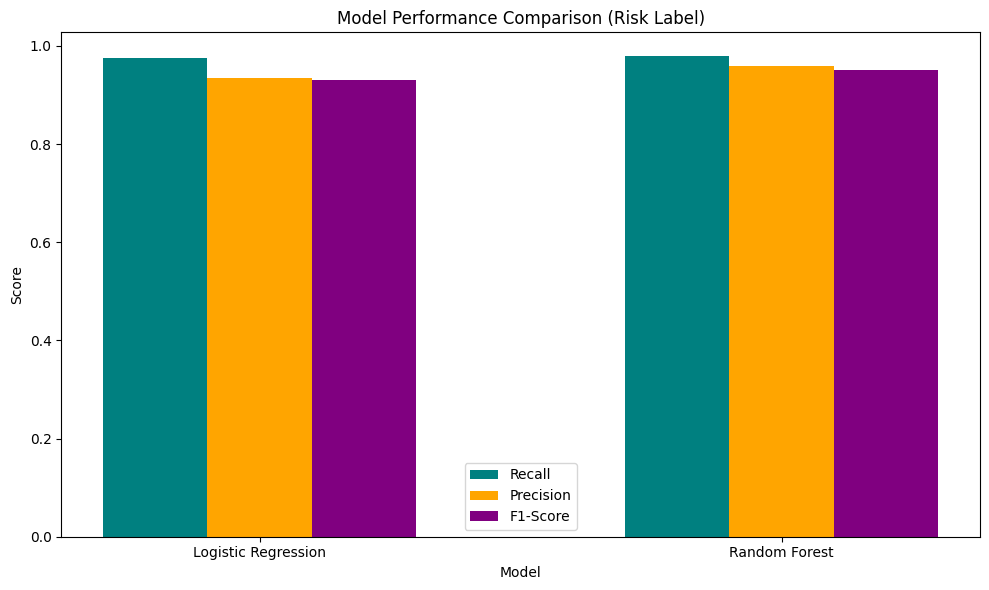

<Figure size 600x600 with 0 Axes>

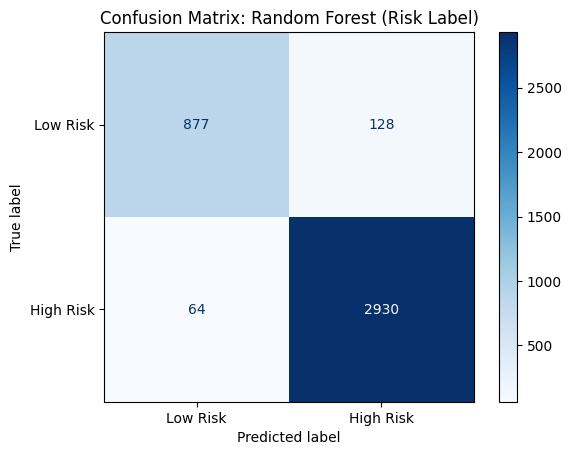

<Figure size 600x600 with 0 Axes>

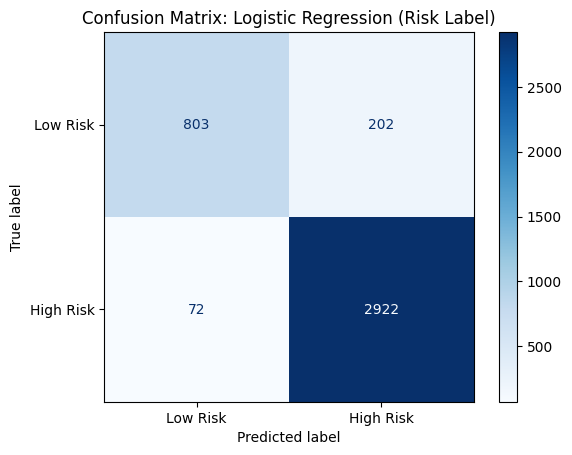

<Figure size 640x480 with 0 Axes>

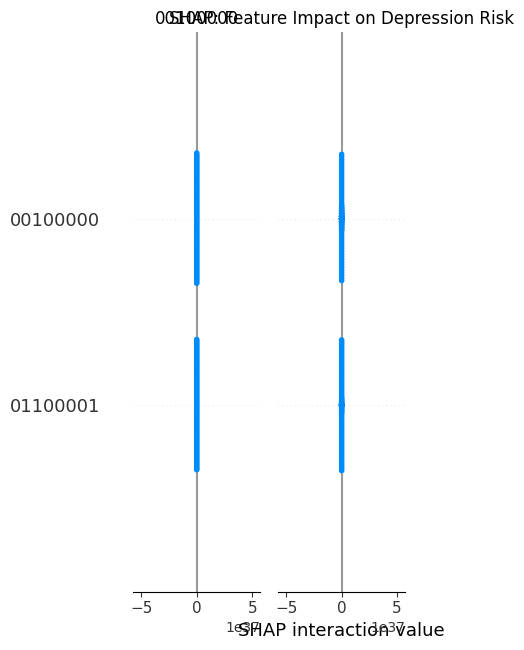

In [54]:
if __name__ == "__main__":
    # This executes all the previous data loading, preprocessing, training, and evaluation steps.
    rf_model, lr_model, tfidf_vec, sentiment_analyzer, label_encoder, _ = run_pipeline() # Execute the main pipeline and unpack returned components


    # This function takes user input (tweet text or URL) and returns predictions and suggestions.
    def predict_tweet_gradio(user_input):
        text_to_process = user_input # Start with the raw user input
        tweet_content_output = "" # Initialize an empty string for scraped tweet content

        if user_input.startswith("http"): # Check if the input is a URL
            # If the input is a URL, try to scrape the tweet content.
            retrieved_text = get_tweet_from_url(user_input) # Attempt to get tweet text from the URL
            if retrieved_text.startswith("ERROR:"): # If there was an error during scraping
                # If URL scraping fails, display the error and prompt the user.
                return retrieved_text, "N/A", "Please check the URL or enter text manually.", "" # Return error message and prompt
            else:
                # If successful, use the scraped text for processing and display it.
                text_to_process = retrieved_text # Use the scraped text for prediction
                tweet_content_output = retrieved_text # Store the scraped text for display

        # Preprocess the text: clean it, extract TF-IDF features, sentiment, and length.
        clean_in = clean_tweet(text_to_process) # Clean the text using our cleaning function
        feat_tfidf = tfidf_vec.transform([clean_in]).toarray() # Transform cleaned text into TF-IDF features
        feat_sent = sentiment_analyzer.polarity_scores(clean_in)['compound'] # Get VADER compound sentiment score
        feat_len = len(clean_in) # Get the length of the cleaned text

        # Combine all features into a single array for the model.
        feat_full = np.hstack([feat_tfidf, [[feat_sent, feat_len]]]) # Horizontally stack all features for the model input

        # Make a prediction using the Logistic Regression model (lr_model).
        # The model outputs a risk label (0/1) and an encoded intent.
        pred_raw = lr_model.predict(feat_full) # Get raw predictions from the Logistic Regression model

        # Decode the numerical intent prediction back into a human-readable label.
        try:
            intent_res = label_encoder.inverse_transform([pred_raw[0][1]])[0] # Decode the predicted intent from numerical to text
        except:
            intent_res = "Unknown" # Fallback for unknown intents if decoding fails

        # Map the intent label to a more descriptive risk level.
        if intent_res == "Cry for Help": # Check for 'Cry for Help' intent
            risk_res = "High Risk" # Assign 'High Risk'
        elif intent_res == "Loneliness": # Check for 'Loneliness' intent
            risk_res = "Moderate Risk" # Assign 'Moderate Risk'
        elif intent_res == "Venting": # Check for 'Venting' intent
            risk_res = "Low Risk" # Assign 'Low Risk'
        elif intent_res == "Neutral": # Check for 'Neutral' intent
            risk_res = "No Risk" # Assign 'No Risk'
        else:
            risk_res = "Uncertain Risk" # Assign 'Uncertain Risk' for other cases

        # Get a wellness suggestion based on the predicted intent.
        suggestion = get_wellness_suggestion(intent_res) # Get a wellness suggestion based on the determined intent

        # Return all the results to be displayed in the Gradio interface.
        return risk_res, intent_res, suggestion, tweet_content_output # Return the predicted risk, intent, suggestion, and tweet content


    # Create the Gradio interface.
    interface = gr.Interface(
        fn=predict_tweet_gradio, # The function to run when the user interacts with the UI.
        inputs=gr.Textbox(lines=5, label="Enter tweet text or a Twitter URL..."), # User input field as a multi-line textbox
        outputs=[
            gr.Textbox(label="Risk Level"), # Display predicted risk.
            gr.Textbox(label="Intent"),     # Display predicted intent.
            gr.Textbox(label="Wellness Suggestion", lines=4), # Display wellness advice.
            gr.Textbox(label="Tweet Content", lines=5) # Display scraped tweet content (if URL was used).
        ],
        title="Depression Risk and Intent Classifier for Tweets", # Title of the Gradio app.
        description="Enter a tweet or a Twitter URL to get a depression risk assessment, intent classification, and a wellness suggestion.", # Description.
        theme='gradio/soft', # theme.
    )

    # Launch the Gradio interface.
    interface.launch() # Start the Gradio web interface

### Test Cases for Depression Risk and Intent Classifier

Here are some example inputs and their expected classifications and suggestions. These can be used to test the Gradio interface.

---

#### Test Case 1: Cry for Help (High Risk)
*   **Input:** "I can't go on anymore. The pain is too much, I just want it to end."
*   **Expected Risk Level:** High Risk
*   **Expected Intent:** Cry for Help
*   **Expected Wellness Suggestion:** 🔴 URGENT: High distress detected. Please contact a helpline immediately. Grounding: Name 5 things you can see.

---

#### Test Case 2: Venting (Moderate Risk)
*   **Input:** "Feeling so overwhelmed and frustrated with everything today. Just a really bad day."
*   **Expected Risk Level:** Moderate Risk
*   **Expected Intent:** Venting
*   **Expected Wellness Suggestion:** 🔵 Insight: Emotional release is healthy. Suggestion: Take time off or try expressive journaling to process these feelings.

---

#### Test Case 3: Loneliness (Low Risk)
*   **Input:** "Wish I had someone to talk to. It gets really lonely sometimes being by myself."
*   **Expected Risk Level:** Low Risk
*   **Expected Intent:** Loneliness
*   **Expected Wellness Suggestion:** 🟡 Insight: Isolation detected. Suggestion: Reach out to a trusted friend or join an online community.

---

#### Test Case 4: Neutral (No Risk)
*   **Input:** "Just finished a great book! Highly recommend 'Project Hail Mary'."
*   **Expected Risk Level:** No Risk
*   **Expected Intent:** Neutral
*   **Expected Wellness Suggestion:** 🟢 Status: No risk detected. Suggestion: Maintain current self-care routine.

---

#### Test Case 5: Ambiguous/Mixed Sentiment
*   **Input:** "I'm trying to stay positive but it's hard when nothing goes right. I just want to feel happy again."
*   **Expected Risk Level:** Moderate Risk (could lean towards Venting)
*   **Expected Intent:** Venting
*   **Expected Wellness Suggestion:** 🔵 Insight: Emotional release is healthy. Suggestion: Take time off or try expressive journaling to process these feelings.

---

#### Test Case 6: URL Example (Requires a public tweet URL)
*   **Input:** `https://twitter.com/example_user/status/1234567890123456789` (Replace with an actual public tweet URL for testing)
*   **Expected Risk Level:** Varies based on tweet content
*   **Expected Intent:** Varies based on tweet content
*   **Expected Wellness Suggestion:** Varies based on tweet content
*   **Expected Tweet Content:** The scraped text from the provided URL.

**Note:** For the URL test case, the actual output will depend on the content of the tweet at the provided URL and whether the `get_tweet_from_url` function can successfully scrape it. You may need to find a public tweet URL to test this effectively.